# Final Project Report: Predicting Newsletter Subscription in Minecraft Players
**Broad Question:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? <br>
**Specific Question:** How does age and play time predict the likelihood of an individual subscribing to a game-related newsletter? 

## Introduction

## Methods & Results
1. **Load Data**: Read `players.csv`.<br>
2. **Wrangle/Clean**: Impute missing values.<br>
3. **Summarize**: Compute means and proportions of subscribe.<br>
4. **Visualize**: Plot playtime and age against subscribe.<br>
5. **Analyze**: Use KNN classification to predict `subscribe` with `played_hours` and `Age`.<br>
6. **Visualize Results**: Scatterplot of predictions.<br>

In [2]:
# Load libraries
library(tidymodels)
library(dplyr)
library(ggplot2)

# 1. Load data
url <- "https://raw.githubusercontent.com/prabhnoor-k/DSCI-100-Project/refs/heads/main/players.csv"
players <- read.csv(url)

# 2. Wrangle and clean
players <- players |>
    select(subscribe, played_hours, Age) |>
    mutate(
        subscribe = as.factor(subscribe)  # Convert logical to factor for classification
  )

players_recipe <- recipe(~ ., data = players) |>
  step_impute_mean(Age) |>   # impute missing age
  prep()
players <- bake(players_recipe, new_data = players)

# display data
head(players)
tail(players)

# 3. Summary
summary_table <- players |>
    summarise(
        Mean_Played_Hours_for_all = mean(played_hours),
        Mean_Age_for_all = mean(Age),
        Prop_Subscribed = mean(as.numeric(subscribe) - 1))

# display the summary
summary_table

subscribe,played_hours,Age
<fct>,<dbl>,<int>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


subscribe,played_hours,Age
<fct>,<dbl>,<int>
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17
TRUE,0.2,21


Mean_Played_Hours_for_all,Mean_Age_for_all,Prop_Subscribed
<dbl>,<dbl>,<dbl>
5.845918,20.52551,0.7346939


In [4]:
# Splitting the Data 

split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(split)
players_test <- testing(split)
glimpse(train_data) #used to view data properly

Rows: 147
Columns: 3
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.0, 0.0, 0.1, 0.0, 1.4, 0.0, 0.0, 0.1, 0.0, 0.0, 0.…
$ Age          <int> 17, 21, 22, 18, 33, 25, 24, 23, 22, 28, 21, 23, 17, 18, 1…


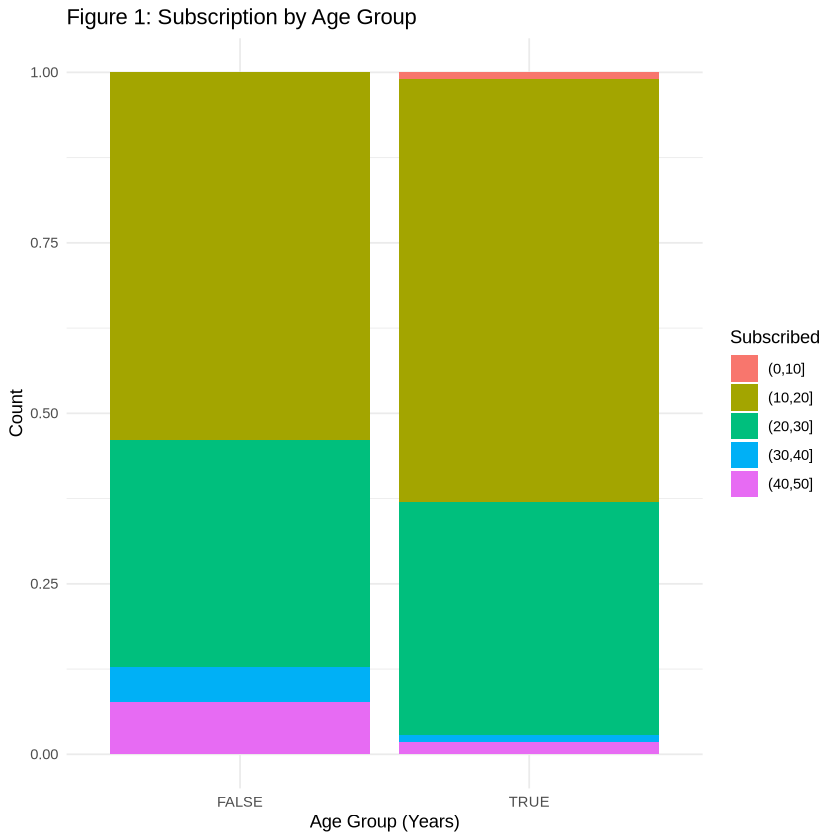

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


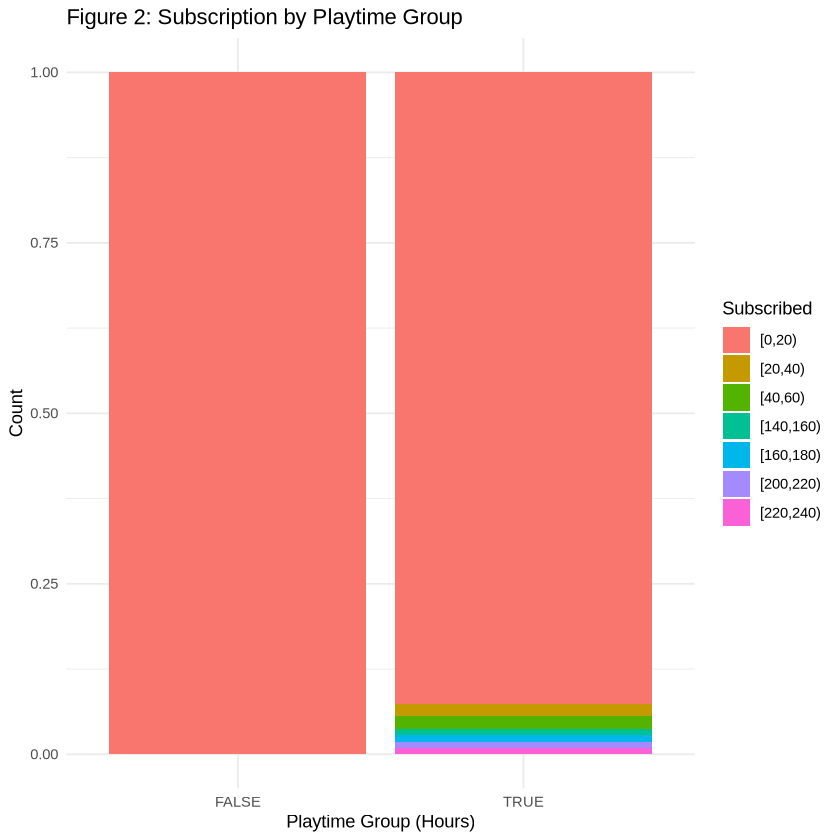

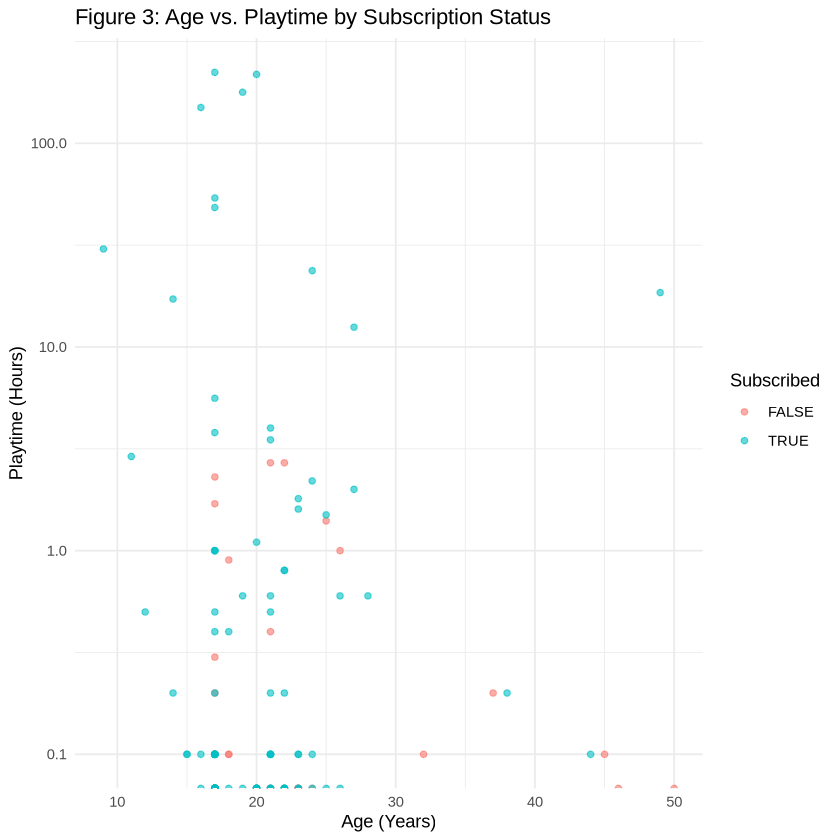

In [11]:
# 4. Visualization 


# Figure 1: Bar plot of Subscription by Age Group
age_bins <- players_train |>
    mutate(Age_Group = cut(Age, breaks = seq(0, 50, by = 10))) 
fig1 <- ggplot(age_bins, aes(x = subscribe, fill = Age_Group)) +
    geom_bar(position = "fill") +
    labs(x = "Age Group (Years)", y = "Count", 
        title = "Figure 1: Subscription by Age Group", fill = "Subscribed") +
    theme_minimal()

fig1

# Figure 2: Bar plot of Playtime vs. Subscription
playtime_bins <- players_train |>
      mutate(Playtime_Group = cut(played_hours, breaks = seq(0, 240, by = 20), right = FALSE))  
fig2 <- ggplot(playtime_bins, aes(x = subscribe, fill = Playtime_Group)) +
    geom_bar(position = "fill") +
    labs(x = "Playtime Group (Hours)", y = "Count", 
        title = "Figure 2: Subscription by Playtime Group", fill = "Subscribed") +
    theme_minimal()

fig2

# Figure 3: Scatterplot of Age vs. Playtime by Subscription
    fig3 <- ggplot(players_train, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (Years)", y = "Playtime (Hours)", 
        title = "Figure 3: Age vs. Playtime by Subscription Status", color = "Subscribed") +
        scale_y_log10()+
    theme_minimal()


fig3